# Warsaw Air Pollution

<span style="color: gray; font-size:1em;">Mateusz Zajac</span>
<br><span style="color: gray; font-size:1em;">Jul-2020</span>


## Table of Contents
- [Part I - Log Transformation](#log)
- [Part II - Lag Features](#lag)
- [Part III - Rolling Mean Features](#roll)
- [Part IV - Mean & Median Aggregations](#mm)
- [Part V - Dummy Variables](#dummy)
- [Part VI - Factorize Categorical Variables](#factor)
- [Part VII - Custom Combinations](#custom)

In [1]:
import pandas as pd
import numpy as np

import datetime
import calendar
import itertools

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [4]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019.h5', key='df')

In [5]:
# df = pd.read_hdf('data/warsaw_air_pollution_2015-2019.h5')

In [6]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,unknown,33.90,0.0,2.733,260.0,6.93,71.8204,68.982316,1,1,1,3,1,2015,0,Winter,58.400547,60.969357
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,0.0,0.0,1027.7,Overcast,33.81,0.0,2.733,260.0,6.93,42.6996,48.707108,2,1,1,3,1,2015,0,Winter,50.865866,42.960510
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,0.0,0.0,1027.7,Foggy,33.81,0.0,1.244,251.0,6.93,38.2824,37.986883,3,1,1,3,1,2015,0,Winter,43.679332,37.038594
4,2015-01-01 04:00:00,26.41,1.0,32.89,0.97,fog,0.0,0.0,1027.7,Foggy,33.73,0.0,1.152,251.0,8.96,35.4194,33.675489,4,1,1,3,1,2015,0,Winter,36.976514,32.364739


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             43848 non-null  datetime64[ns]
 1   apparentTemperature  43848 non-null  float64       
 2   cloudCover           43848 non-null  float64       
 3   dewPoint             43848 non-null  float64       
 4   humidity             43848 non-null  float64       
 5   icon                 43848 non-null  object        
 6   precipIntensity      43848 non-null  float64       
 7   precipProbability    43848 non-null  float64       
 8   pressure             43848 non-null  float64       
 9   summary              43848 non-null  object        
 10  temperature          43848 non-null  float64       
 11  uvIndex              43848 non-null  float64       
 12  visibility           43848 non-null  float64       
 13  windBearing          43848 non-

<a id='log'></a>
# Part I - Log Transformation

In [8]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(8,4))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

In [9]:
# getting log1p for PM25 and 2 other skewed distributions, that seems to be important
# while looking at the correlation matrix

log_feats = ['humidity', 'windSpeed', 'PM25_nie', 'PM25_wok']

for feat in log_feats:
    df['{}_log'.format(feat)] = np.log1p(df[feat].values)

In [10]:
# assign meaningful column names
df.rename(columns={'season_Autumn':'Autumn', 'season_Spring':'Spring', 
                           'season_Summer':'Summer', 'season_Winter':'Winter'}, inplace=True)

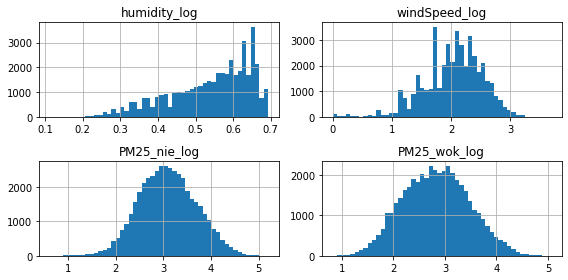

In [11]:
log_feats = ['humidity_log', 'windSpeed_log', 'PM25_nie_log', 'PM25_wok_log']

draw_histograms(df, log_feats, 2, 2)

In [12]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489,0.625938,2.070653,3.960878,3.957379
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,unknown,33.90,0.0,2.733,260.0,6.93,71.8204,68.982316,1,1,1,3,1,2015,0,Winter,58.400547,60.969357,0.636577,2.070653,4.287996,4.248243
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,0.0,0.0,1027.7,Overcast,33.81,0.0,2.733,260.0,6.93,42.6996,48.707108,2,1,1,3,1,2015,0,Winter,50.865866,42.960510,0.647103,2.070653,3.777339,3.906148
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,0.0,0.0,1027.7,Foggy,33.81,0.0,1.244,251.0,6.93,38.2824,37.986883,3,1,1,3,1,2015,0,Winter,43.679332,37.038594,0.672944,2.070653,3.670777,3.663225
4,2015-01-01 04:00:00,26.41,1.0,32.89,0.97,fog,0.0,0.0,1027.7,Foggy,33.73,0.0,1.152,251.0,8.96,35.4194,33.675489,4,1,1,3,1,2015,0,Winter,36.976514,32.364739,0.678034,2.298577,3.595102,3.546033


<a id='lag'></a>
# Part II - Lag Features

In [13]:
# create 1h and 24h lags
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'humidity_log',
         'precipIntensity', 'precipProbability', 'pressure', 'temperature', 'uvIndex',
         'visibility', 'windBearing', 'windSpeed', 'windSpeed_log']
lags = [1, 24]

for lag in lags:
    for feat in feats:
        df['{0}_lag{1}h'.format(feat, lag)] = df[feat].shift(lag).astype('float32')

In [14]:
# backfill missing values
lag_cols = [col for col in df.columns if 'lag' in col]

for col in lag_cols:
    df[col] = df[col].fillna(method ='bfill')

<a id='roll'></a>
# Part III - Rolling Mean Features

In [15]:
rolls = [12, 24, 72, 168]

# create rolling means
for roll in rolls:
    for feat in feats:
        df['{0}_rolling{1}h'.format(feat, roll)] = df[feat].rolling(roll).mean()

In [16]:
# backfill missing values
rolling_cols = [col for col in df.columns if 'rolling' in col]

for col in rolling_cols:
    df[col] = df[col].fillna(method ='bfill')

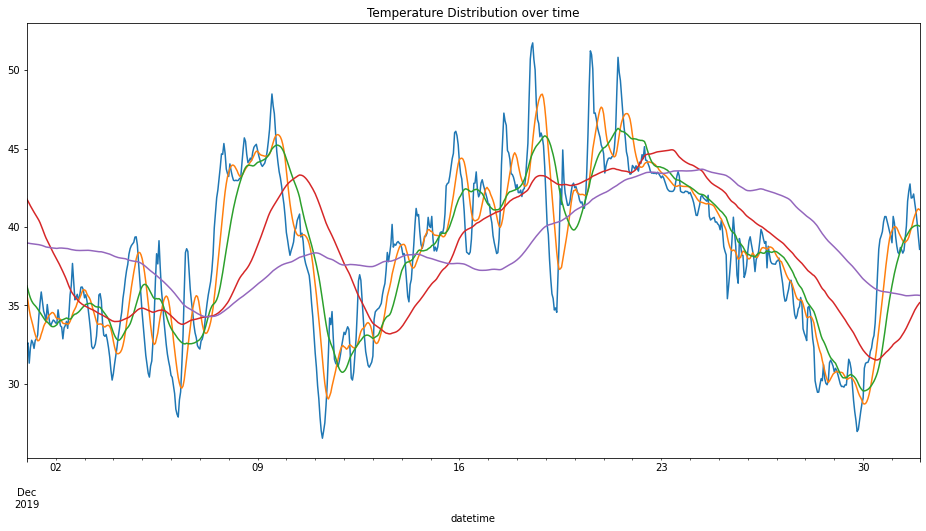

In [17]:
# check the moving averages for Dec-19 on a chart
feats = ['temperature', 'temperature_rolling12h', 'temperature_rolling24h', 'temperature_rolling72h', 'temperature_rolling168h']


for x in feats:
    df_copy = df.copy()
    df_copy.index = df.datetime
    plt.title('Temperature Distribution over time')
    df_copy[-744:][x].plot(figsize=(16,8));

<a id='mm'></a>
# Part IV - Mean & Median Aggregations

In [18]:
# create mean and median per day for the below features

feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'humidity_log',
         'precipIntensity', 'precipProbability', 'pressure', 'temperature', 'uvIndex',
         'visibility', 'windBearing', 'windSpeed', 'windSpeed_log',
         'PM25_nie', 'PM25_wok', 'PM25_nie_log', 'PM25_wok_log']
         
aggreg = ['mean', 'median']


# group by day, then compute mean and median value
dfs_day = []

for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_day'.format(aggs, feat)] = df.groupby('dayofyear')[feat].agg(aggs).reset_index()
        dfs_day.append(globals()['{0}_{1}_per_day'.format(aggs, feat)])


# group by month, then compute mean and median value
dfs_month = []

for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_month'.format(aggs, feat)] = df.groupby('month')[feat].agg(aggs).reset_index()
        dfs_month.append(globals()['{0}_{1}_per_month'.format(aggs, feat)])
        

In [19]:
# assign meaningful column names
for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_day'.format(aggs, feat)].rename(columns={feat: '{0}_{1}_per_day'.format(aggs, feat)}, inplace=True)
        globals()['{0}_{1}_per_month'.format(aggs, feat)].rename(columns={feat: '{0}_{1}_per_month'.format(aggs, feat)}, inplace=True)       

In [20]:
# merge dataframes
for x in dfs_day:
    df = pd.merge(df, x, on='dayofyear', how='left')

In [21]:
# merge dataframes
for y in dfs_month:
    df = pd.merge(df, y, on='month', how='left')

#### Calculate deviations from the daily or monthly mean and median

In [22]:
# calculate hourly temperature difference from the daily or monthly mean and median
df['temperature_diff_for_day_median'] = df['median_temperature_per_day'] - df['temperature']
df['temperature_diff_for_day_mean'] = df['mean_temperature_per_day'] - df['temperature']
df['temperature_diff_for_month_median'] = df['median_temperature_per_month'] - df['temperature']
df['temperature_diff_for_month_mean'] = df['mean_temperature_per_month'] - df['temperature']

# calculate hourly humidity difference from the daily or monthly mean and median
df['humidity_diff_for_day_median'] = df['median_humidity_per_day'] - df['humidity']
df['humidity_diff_for_day_mean'] = df['mean_humidity_per_day'] - df['humidity']
df['humidity_diff_for_month_median'] = df['median_humidity_per_month'] - df['humidity']
df['humidity_diff_for_month_mean'] = df['mean_humidity_per_month'] - df['humidity']

# calculate hourly windSpeed difference from the daily or monthly mean and median
df['windSpeed_diff_for_day_median'] = df['median_windSpeed_per_day'] - df['windSpeed']
df['windSpeed_diff_for_day_mean'] = df['mean_windSpeed_per_day'] - df['windSpeed']
df['windSpeed_diff_for_month_median'] = df['median_windSpeed_per_month'] - df['windSpeed']
df['windSpeed_diff_for_month_mean'] = df['mean_windSpeed_per_month'] - df['windSpeed']

# calculate hourly windBearing difference from the daily or monthly mean and median
df['windBearing_diff_for_day_median'] = df['median_windBearing_per_day'] - df['windBearing']
df['windBearing_diff_for_day_mean'] = df['mean_windBearing_per_day'] - df['windBearing']
df['windBearing_diff_for_month_median'] = df['median_windBearing_per_month'] - df['windBearing']
df['windBearing_diff_for_month_mean'] = df['mean_windBearing_per_month'] - df['windBearing']

In [23]:
# check correctness of the calculation for temp
df[['median_temperature_per_month', 'temperature', 'temperature_diff_for_month_median']].head()

,median_temperature_per_month,temperature,temperature_diff_for_month_median
0,31.94,32.93,-0.99
1,31.94,33.90,-1.96
2,31.94,33.81,-1.87
3,31.94,33.81,-1.87
4,31.94,33.73,-1.79


In [24]:
# check correctness of the calculation for wind speed
df[['mean_windSpeed_per_month', 'windSpeed', 'windSpeed_diff_for_month_mean']].head()

,mean_windSpeed_per_month,windSpeed,windSpeed_diff_for_month_mean
0,8.034874,6.93,1.104874
1,8.034874,6.93,1.104874
2,8.034874,6.93,1.104874
3,8.034874,6.93,1.104874
4,8.034874,8.96,-0.925126


<a id='dummy'></a>
# Part V - Dummy Variables

In [25]:
# get dummies
df = pd.get_dummies(data=df, columns=['season'])

# assign meaningful column names
df.rename(columns={'season_Autumn':'Autumn', 'season_Spring':'Spring', 
                           'season_Summer':'Summer', 'season_Winter':'Winter'}, inplace=True)

<a id='factor'></a>
# Part VI - Factorize Categorical Variables

In [26]:
df['icon_num'] = (df['icon'].factorize()[0]).astype('uint8')

<a id='Custom'></a>
# Part VII - Custom Combinations

In [27]:
# substract 24h MA from 72h MA
df['temperature_24-72h_ma_diff'] = df['temperature_rolling72h'] - df['temperature_rolling24h']
df['humidity_24-72h_ma_diff'] = df['humidity_rolling72h'] - df['humidity_rolling24h']
df['windSpeed_24-72h_ma_diff'] = df['windSpeed_rolling72h'] - df['windSpeed_rolling24h']
df['windBearing_24-72h_ma_diff'] = df['windBearing_rolling72h'] - df['windBearing_rolling24h']

In [28]:
# create combination of features based on a business week and ceratin type of meteo measures
df['isHumidWorkingDay'] = ((df['humidity'] > 0.5) & (df['IsWeekend'] == 0)).astype('uint8')
df['isColdWorkingDay'] = ((df['temperature'] < 40) & (df['IsWeekend'] == 0)).astype('uint8')
df['isWindlessWorkingDay'] = ((df['windSpeed'] < 8) & (df['IsWeekend'] == 0)).astype('uint8')

df['isWindlessColdHumidWorkingDay'] = ((df['humidity'] > 0.5) & (df['temperature'] < 40) & (df['windSpeed'] < 8) & (df['IsWeekend'] == 0)).astype('uint8')

In [29]:
# create combination of features based on hours that people are mainly home during a business week and ceratin type of meteo measures
df['NonWorkingHoursInWeek'] = (((df['hour'].between(0, 8)) | (df['hour'].between(20, 23))) & (df['IsWeekend'] == 0)).astype('uint8')

df['NonWorkingHumidHoursInWeek'] = ((df['NonWorkingHoursInWeek'] == 1) & (df['isHumidWorkingDay'] == 1)).astype('uint8')
df['NonWorkingColdHoursInWeek'] = ((df['NonWorkingHoursInWeek'] == 1) & (df['isColdWorkingDay'] == 1)).astype('uint8')
df['NonWorkingWindlessHoursInWeek'] = ((df['NonWorkingHoursInWeek'] == 1) & (df['isWindlessWorkingDay'] == 1)).astype('uint8')
df['NonWorkingWindlessColdHumidHoursInWeek'] = ((df['NonWorkingHoursInWeek'] == 1) & (df['isWindlessColdHumidWorkingDay'] == 1)).astype('uint8')

In [30]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,humidity_log_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,windSpeed_log_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,humidity_log_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,windSpeed_log_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,humidity_log_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,windSpeed_log_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,humidity_log_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,windSpeed_log_rolling24h,apparentTemperature_rolling72h,cloudCover_rolling72h,dewPoint_rolling72h,humidity_rolling72h,humidity_log_rolling72h,precipIntensity_rolling72h,precipProbability_rolling72h,pressure_rolling72h,temperature_rolling72h,uvIndex_rolling72h,visibility_rolling72h,windBearing_rolling72h,windSpeed_rolling72h,windSpeed_log_rolling72h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,humidity_log_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,windSpeed_log_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_humidity_log_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_windSpeed_log_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_humidity_log_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_windSpeed_log_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_humidity_log_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_windSpeed_log_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_humidity_log_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_windSpeed_log_per_month,median_PM

In [31]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 220 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   datetime                                datetime64[ns]
 1   apparentTemperature                     float64       
 2   cloudCover                              float64       
 3   dewPoint                                float64       
 4   humidity                                float64       
 5   icon                                    object        
 6   precipIntensity                         float64       
 7   precipProbability                       float64       
 8   pressure                                float64       
 9   summary                                 object        
 10  temperature                             float64       
 11  uvIndex                                 float64       
 12  visibility                              float

In [32]:
# check if missing values exist in the dataset
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

In [33]:
## save dataframes to hdf
df.to_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df', format='t')